In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#set stepsize patterns
H_GRDESC = [1]
H_2 = [2.9, 1.5] # taking nu = 0.1
H_3 = [1.5, 4.9, 1.5]
H_7 = [1.5, 2.2, 1.5, 12.0, 1.5, 2.2, 1.5]
H_15 = [1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4, 29.7, 1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4]
H_31 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 72.3, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_63 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 164.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_127 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 370.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]

H = [H_GRDESC,H_2,H_3,H_7,H_15,H_31,H_63,H_127]
H = [H_GRDESC,H_2]

# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#evaluate objective function without regularizer
def objective1(outputs, labels, model = None):
    # Convert labels to one-hot encoding
    labels_onehot = torch.zeros_like(outputs)
    for i, label in enumerate(labels):
        labels_onehot[i][label] = 1
    
    return torch.norm(outputs - labels_onehot, p=2 , dim=1).pow(2).mean()

#...with regularizer
def objective2(outputs, labels, model):
    return objective1(outputs, labels, model) + torch.norm(model.linear.weight, p=2).pow(2).mean()


# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(784, 10, bias=False) # 28x28 = 784 input features, 10 output classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        return self.linear(x)

    # Define the custom non-constant step sizes
    def step_size_schedule(self, epoch, H, image = None):
        h = H[(epoch-1) % len(H)]
        # L = 2 * torch.norm(image.view(image.size(0), -1), p=2)**2
        return h / 87.8

   
# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) # Batch size of 1
print(f"Number of training examples: {len(train_dataset)}")

# Load MNIST test data
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())

# Extract images (X_test) and labels (y_test) from the test dataset
X_test = test_dataset.data[:1000].unsqueeze(1).float().to(device)  # Add a channel dimension and convert to float
y_test = test_dataset.targets[:1000].to(device)
print(f"Number of test examples: {len(X_test)}")


Number of training examples: 60000
Number of test examples: 1000
tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,

In [14]:
L = 0
for images, _ in train_loader:
    L += torch.norm(images.view(images.size(0), -1), p=2)**2

print(f"Estimated L: {L/len(train_dataset)}")

Estimated L: 87.80987548828125


In [15]:
losses_H = []
test_errors_H = []
for H_i in H:
    criterion = objective1 
    # Create the linear model
    model = LinearModel().to(device)
    nn.init.xavier_uniform_(model.linear.weight) # Initialize the weights using Xavier initialization
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Lists to store the loss values and test errors
    losses = []
    test_errors = []

    # Train the model
    for epoch in tqdm(range(10)):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Update the learning rate
            optimizer.param_groups[0]['lr'] = model.step_size_schedule(epoch, H_i, images)

            output = model(images)
            loss = criterion(output, labels, model) # x is weight, A is image data, b is label data, Ax=b
            loss.backward()
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record the loss
            losses.append(loss.item())

            # Test the model
            # Calculate test error using test data
            with torch.no_grad():
                inputs = X_test.view(X_test.size(0), -1) 
                outputs = model(inputs)
                test_error = criterion(outputs, y_test, model)
            
            test_errors_H.append(test_error)

        print(f"Epoch {epoch+1}: Training Loss = {loss.item()}")
        
    losses_H.append(losses)
    test_errors_H.append(test_errors)


# Save the loss and test error data
np.save('losses_H.npy', losses_H)
np.save('test_errors_H.npy', test_errors_H)


 10%|█         | 1/10 [00:25<03:47, 25.29s/it]

Epoch 1: Training Loss = 0.6164811849594116


 20%|██        | 2/10 [00:51<03:27, 25.88s/it]

Epoch 2: Training Loss = 0.5422504544258118


 30%|███       | 3/10 [01:18<03:03, 26.25s/it]

Epoch 3: Training Loss = 0.5452681183815002


 30%|███       | 3/10 [01:23<03:14, 27.85s/it]


KeyboardInterrupt: 

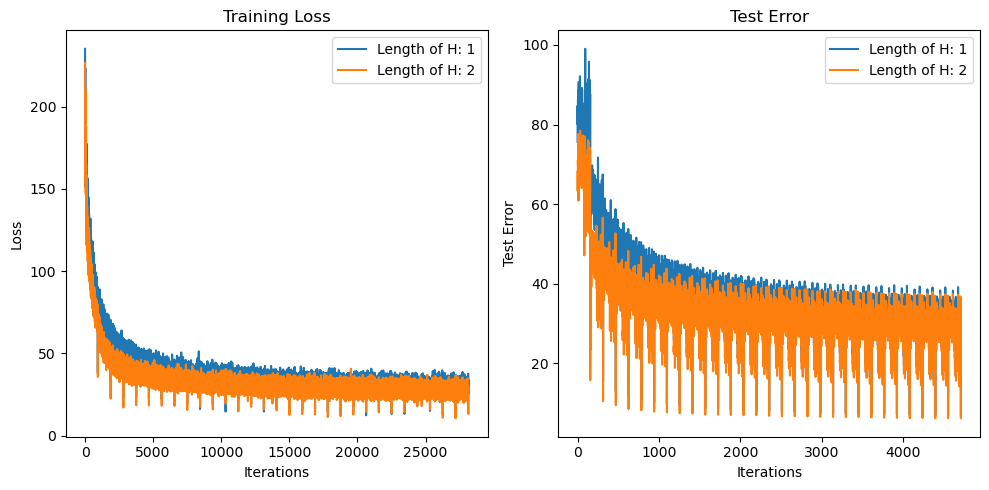

In [ ]:

# Load the loss and test error data
losses_H = np.load('losses_H.npy')
test_errors_H = np.load('test_errors_H.npy')

# Plot losses_H
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i, losses in enumerate(losses_H):
    plt.plot(losses, label=f"Length of H: {len(H[i])}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot test_errors_H
plt.subplot(1, 2, 2)
for i, test_errors in enumerate(test_errors_H):
    plt.plot(test_errors, label=f"Length of H: {len(H[i])}")
plt.xlabel("Iterations")
plt.ylabel("Test Error")
plt.title("Test Error")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
